In [29]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [30]:
# Load the dataset from GitHub
url = "https://raw.githubusercontent.com/mohitgupta-1O1/Kaggle-SMS-Spam-Collection-Dataset-/9823a7f115df8caa24f7b3adfcc770526fbd07e3/spam.csv"

data = pd.read_csv(url, encoding='latin-1')

data = data.rename(columns={'v1': 'label', 'v2': 'message'})
data = data[['label', 'message']]  # Keep only necessary columns

In [31]:
data.shape

(5572, 2)

In [32]:
# Encode labels (spam: 1, ham: 0)
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

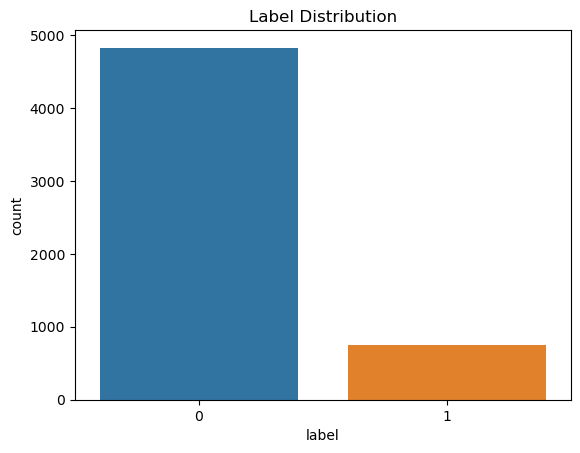

In [33]:
# Visualize label distribution
sns.countplot(x='label', data=data)
plt.title("Label Distribution")
plt.show();

In [34]:
X = data['message']
y = data['label']

X.shape, y.shape

((5572,), (5572,))

In [35]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27
)


In [36]:
# Vectorize text data using TfidfVectorizer
tfidf = TfidfVectorizer(
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [37]:
X_train_tfidf.shape, X_test_tfidf.shape

X_train_tfidf

((4457, 7408), (1115, 7408))

<4457x7408 sparse matrix of type '<class 'numpy.float64'>'
	with 34687 stored elements in Compressed Sparse Row format>

In [38]:
# Initialize models for comparison
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(
        max_iter=1000, random_state=27
    ),
    'SVC': SVC(random_state=27),
    'LinearSVC': LinearSVC(
        max_iter=1000, random_state=27
    )
}

In [39]:
# Evaluate models
for name, model in models.items():    
    model.fit(X_train_tfidf, y_train)    
    y_pred = model.predict(X_test_tfidf)    
    accuracy = accuracy_score(y_test, y_pred)  
    print(f"{name} Accuracy: {accuracy:.4f}")

MultinomialNB()

MultinomialNB Accuracy: 0.9722


LogisticRegression(max_iter=1000, random_state=27)

LogisticRegression Accuracy: 0.9587


SVC(random_state=42)

SVC Accuracy: 0.9776


LinearSVC(random_state=27)

LinearSVC Accuracy: 0.9803


In [40]:
# Select a base model (e.g., MultinomialNB) for hyperparameter tuning
base_model = MultinomialNB()

In [41]:
# Set up hyperparameter grid for GridSearchCV
param_grid = {
    'alpha': [0.1, 0.5, 1.0]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    base_model
    , param_grid
    , cv=5
    , scoring='accuracy'
)

grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0]}, scoring='accuracy')

In [42]:
# Print best hyperparameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'alpha': 0.1}
Best Cross-Validation Accuracy: 0.9820499463997221


In [49]:
# Evaluate best model on test data
best_model = grid_search.best_estimator_

# Now FIT the best_model (MUST DO BEFORE PREDICTING!!! {otherwise, you essentially reset the model! :o })
best_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.1)

In [50]:
y_test_pred = best_model.predict(X_test_tfidf)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9838565022421525


array([[955,   2],
       [ 16, 142]])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       957
           1       0.99      0.90      0.94       158

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



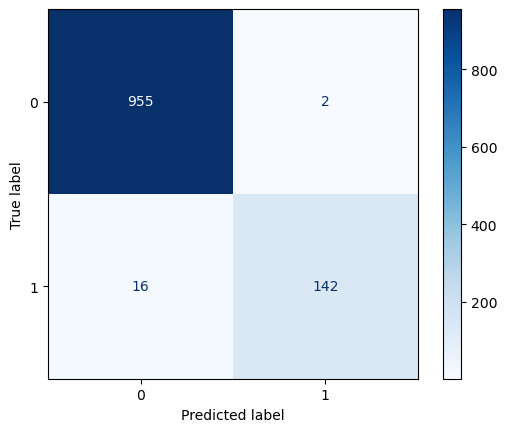

In [51]:
# Plot the confusion matrix

ConfusionMatrixDisplay.from_estimator(
    best_model, X_test_tfidf, y_test
    , cmap='Blues'
);

In [45]:
# Build a pipeline for testing on sample strings
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english'))
    , ('model', best_model)
])

In [46]:
# HAVE TO FIT THE PIPES!!!

# Since the model is already trained, can fit directly to X, y;
pipeline.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('model', MultinomialNB(alpha=0.1))])

In [48]:
# Test pipeline on sample strings
sample_strings = [
    "Congratulations! You've won a free ticket to Bahamas.",
    "Hey, are we still on for lunch tomorrow?",
    "Urgent! Your account has been compromised. Click this link.",
    "Congratulations son! Your Mother is so proud!",
    "Enlarge your portfolio 1000% with my proven investment secrets!"
]

predictions = pipeline.predict(sample_strings)

# Display predictions
for text, label in zip(sample_strings, predictions):
    print(f"Message: {text} -> Prediction: {'Spam' if label == 1 else 'Ham'}\n")

Message: Congratulations! You've won a free ticket to Bahamas. -> Prediction: Spam

Message: Hey, are we still on for lunch tomorrow? -> Prediction: Ham

Message: Urgent! Your account has been compromised. Click this link. -> Prediction: Spam

Message: Congratulations son! Your Mother is so proud! -> Prediction: Ham

Message: Enlarge your portfolio 1000% with my proven investment secrets! -> Prediction: Spam

